# Objectives

- Identify disease biomarkers.

- Build an inductive model.

# Dataset Selection

- Datasets: 191

- Samples: 29.198

### OpenRefine:
A powerful free, open source tool for working with messy data: cleaning it, transforming it from one format into another and extending it with web services and external data.

- Retrieve platform *technology* from [Gene Expression Omnibus](https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/browse/?view=platforms):

  - high-throughput sequencing (64 datasets: 1473 samples)

  - spotted oligonucleotide (35 datasets: 24.119 samples)

  - in situ oligonucleotide (61 datasets: 2987 samples)

  - RT-PCR (28 datasets: 544 samples)

  - other (3 datasets: 75 samples)

- Delete datasets:

  - *technology* = other | [RT-PCR](https://biosistemika.com/blog/qpcr-microarrays-rna-sequencing-choose-one)

  - *dataset* = EMIR00000180 (64 samples) ([samples in common with EMIR00000177 but inconsistent values](./report.numbers))

  - *dataset* = EMIR00000091 | EMIR00000092 | EMIR00000097 | EMIR00000101 (EMIR00000102 partitioning)

# Metadata Preprocessing

- Features: 267

### OpenRefine

- Add dataset-level features.

- Split and transpose key:value features.

- Delete samples:

   - *organism* ≠ Homo sapiens (22 samples)

   - *channel_count* ≠ 1 (189 samples)

   - *molecule* ≠ total RNA (2 samples)

   - EMIR00000090 | EMIR00000008 rows whose disease status is not specified (13 samples, 4 samples)

In [14]:
import pandas as pd


def keep_first_occurrence(row):
    """
    Delete repeated occurrences of the same value in a row
    """
    new_row = []
    for value in row:
        new_row.append(value if value not in new_row else None)
    return pd.Series(new_row, index=row.index)


metadata = pd.read_csv('data/PD.csv', dtype=str).apply(keep_first_occurrence, axis=1)

# Remove columns containing a unique value for all the rows
metadata.drop(metadata.columns[metadata.apply(pd.Series.nunique) == 1], axis=1, inplace=True)

# Remove empty columns
metadata.dropna(axis=1, how='all', inplace=True)

metadata.to_csv('data/PD.csv', index=False)

### OpenRefine

- Merge equivalent features associated to different datasets.

- Rename features consistently.

- Delete irrelevant or redundant features (e.g. *state* has an almost 1:1 relationship with *city*).

- Delete features where missing values ⪆ 98%.

- Refine dataset-level features (based on majority class) using sample-level data: *sample_type*, *disease*, *disease_type*, *body_site*.
        
- Detect *healthy* samples in each dataset exploiting sample description.

- Extract *metastasis* state and *tumor_stage* from sample description.

- Standardize *age*, *sex*, *city*, *disease*, *disease_type* values.

# miRNA Preprocessing 

In [154]:
import pandas as pd


name_conversions = {}
for _, row in pd.read_csv('data/raw/converter.csv', index_col=0).iterrows():
    for i in range(len(row) - 1):
        if row[i] != row[-1]:
            name_conversions[row[i]] = row[-1]
            

def transform_miRNA_name(name):
    """
    Delete whitespaces, standardize separators and remove version suffix from miRNA names. Update miRNA names to the latest version of miRBase.
    """
    name = name.replace(' ', '')
    name = name.replace(',hsa', '|hsa')
    name = name.replace('+hsa', '|hsa')
    name = name.replace('/hsa', '|hsa')
    name = name.replace('_hsa', '|hsa')
    name = name.split('_v1')[0]
    name = name.split('_v2')[0]
    name = name_conversions.get(name, name)
    return name


samples_per_dataset = pd.read_csv('data/PD.csv').groupby('dataset')['sample_id'].agg(list).to_dict()
df_list = []

for dataset in samples_per_dataset.keys():

    df = pd.read_csv(f'data/raw/exp/{dataset}_exp.csv', converters={0: transform_miRNA_name})

    # Delete rows indexed by the same miRNA name (dataset anomaly)
    df = df.drop_duplicates(df.columns[0])

    # Delete rows indexed by miRNA names containing 'plus', 'novel' (unknown miRNA), 'hsa-miR-647+a703' (dataset anomaly), '_var2' (dataset contains identical suffix-free miRNA)
    df = df[df[df.columns[0]].str.contains('plus|novel|hsa-miR-647\+a703|_var2') == False]

    # Transpose data
    df = df.set_index(df.columns[0]).T

    # Remove samples not included in metadata
    df = df.loc[samples_per_dataset[dataset]]
    
    df_list.append(df)

# Concatenate data into a single dataframe
values = pd.concat(df_list)

pd.DataFrame(values.count(axis=0), columns=['samples']).to_csv('data/miRNA.csv')
values.to_csv('data/EXP.csv')

- [Converter](http://mirandola.iit.cnr.it/converter.php)

- [Plus](https://www.tecan.com/hubfs/Tecan_Journal/200702/TecanJournal2007-02_page_16.pdf)

- [Novel](https://academic.oup.com/bfg/article/15/1/65/1742523)

# Visualization

Total samples: 28132


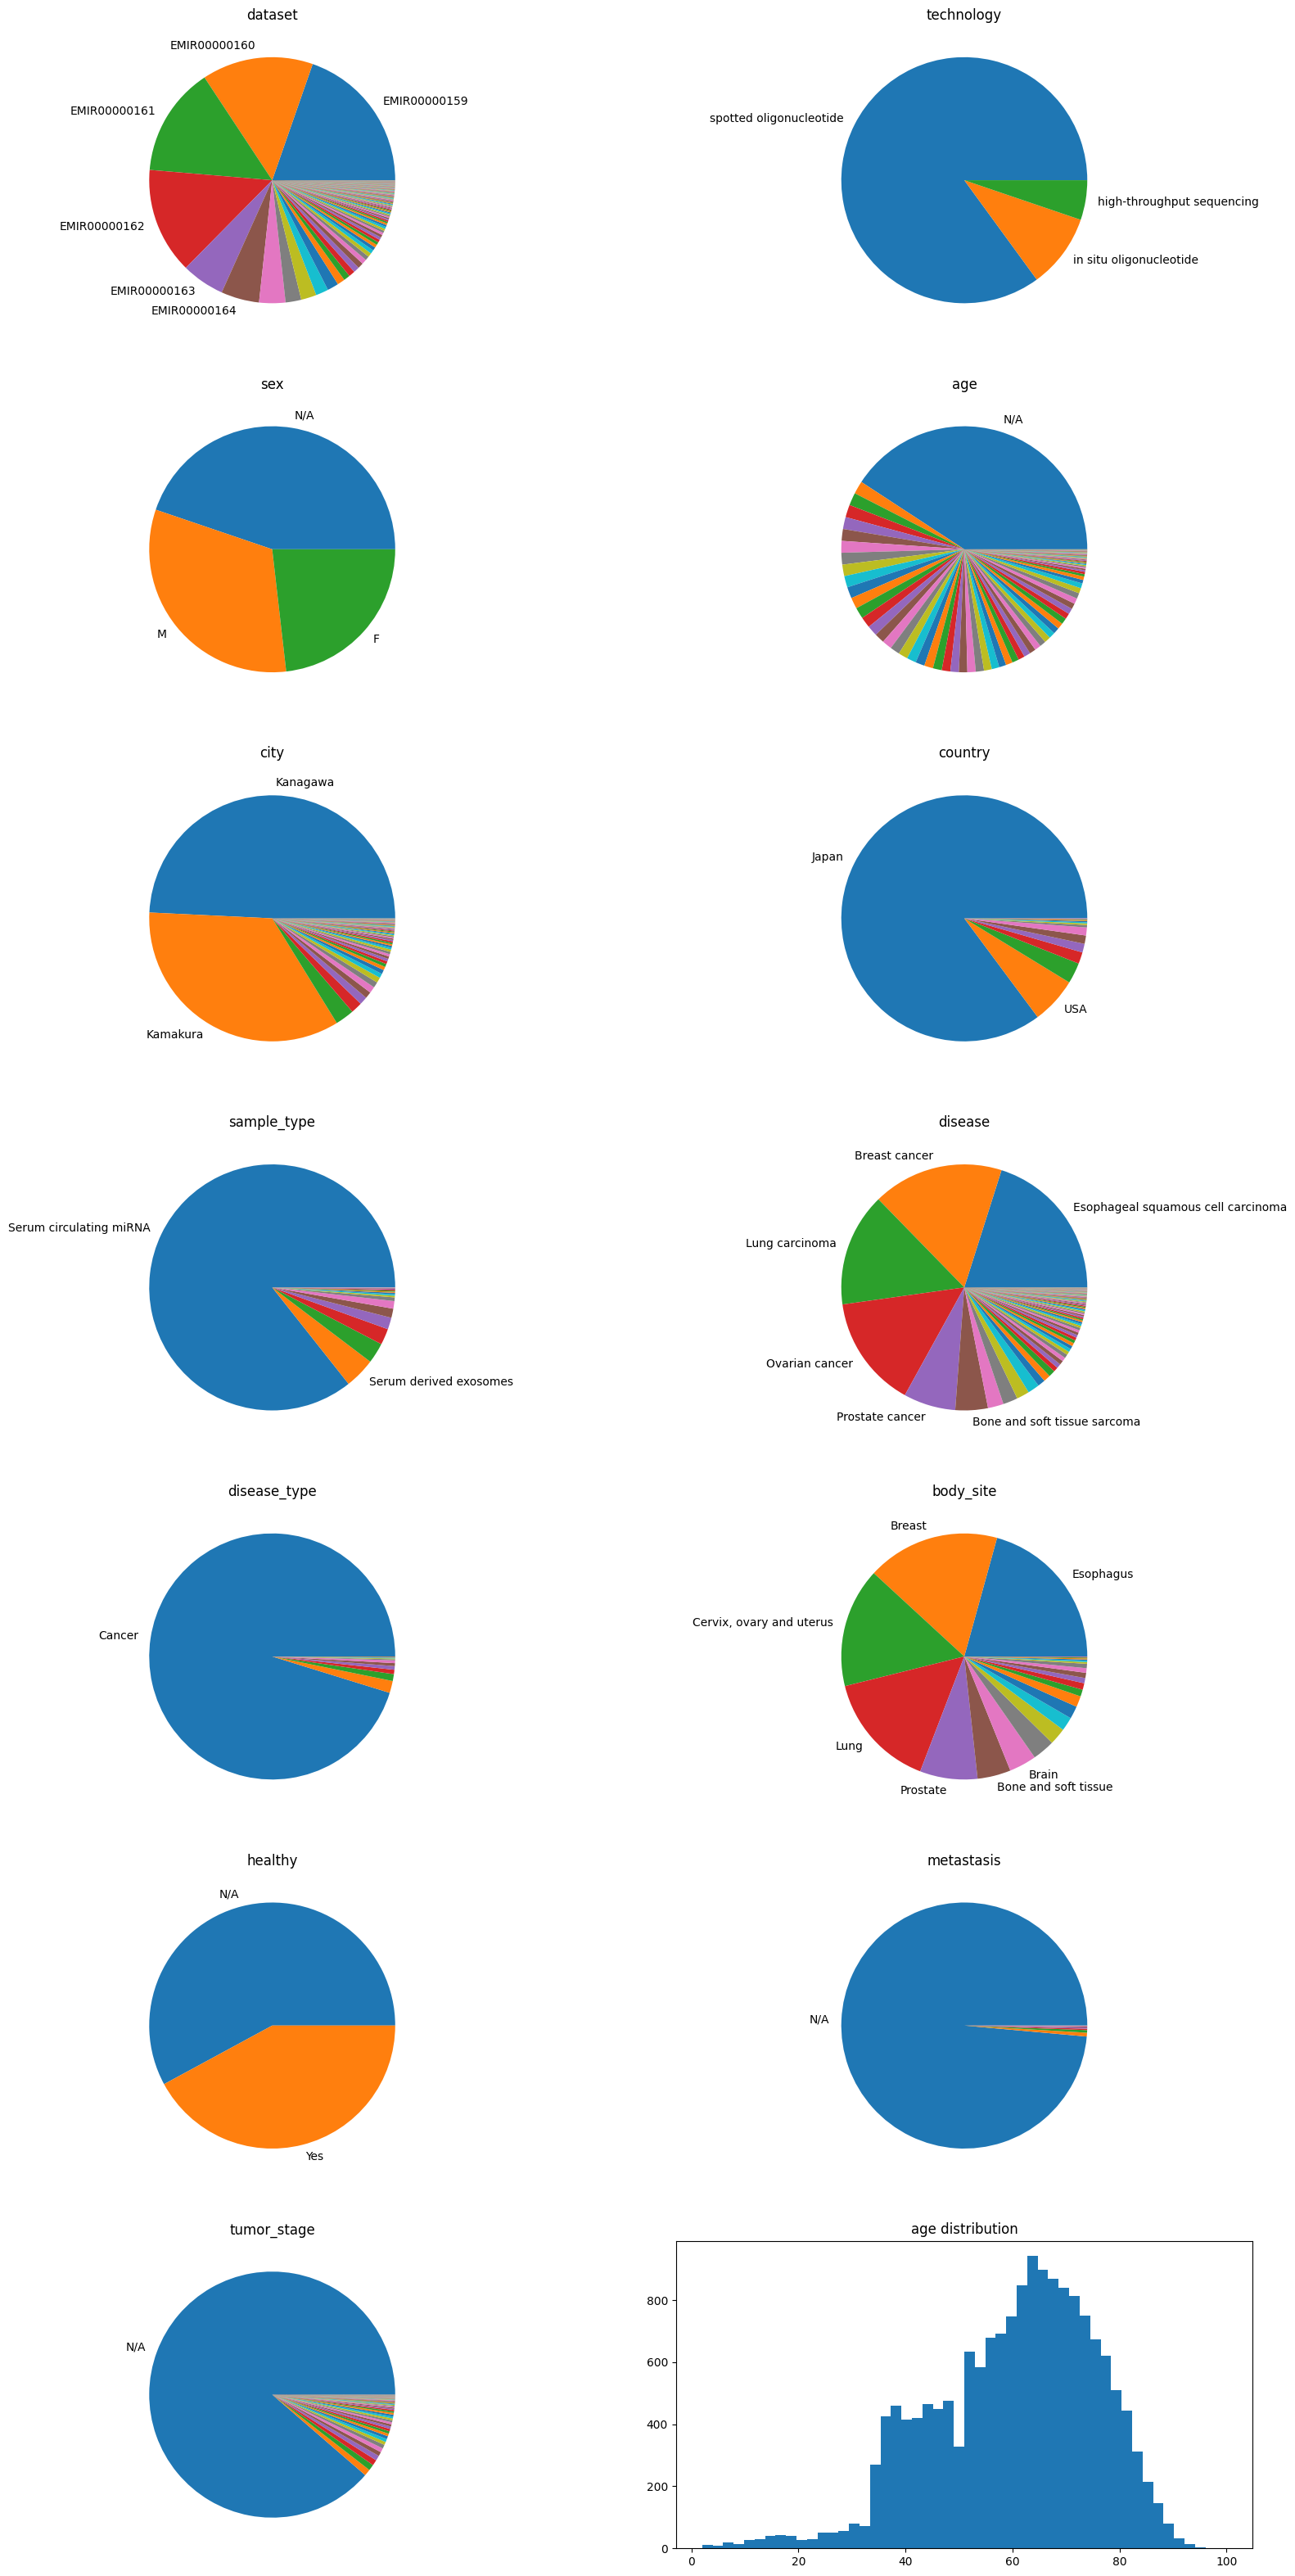

In [155]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data/PD.csv', index_col='sample_id')
print(f'\033[1mTotal samples: {len(df)}')

fig, axs = plt.subplots(7, 2, figsize=(20, 40))
for i, column in enumerate(df.columns):

    counts = df[column].value_counts(dropna=False)
    labels = [label if count > 1000 else '' for count, label in zip(counts, counts.index)]
    labels = ['N/A' if pd.isnull(label) else label for label in labels]
    axs[i//2, i%2].set_title(f'{column}')
    axs[i//2, i%2].pie(counts, labels=labels)

axs[-1, -1].set_title('age distribution')
axs[-1, -1].hist(df['age'], bins=50)

plt.show()

# Issues


- Previous experiment: *disease* attribute extracted from dataset table but each dataset also contains healthy samples.

- Dataset integration is not recommended. If values in multiple datasets are not comparable, generated results are biased:

  - Different datasets use different numeric range: [0,1], [-∞,0], [0,+∞], [-∞,+∞]
  
  - Model will map dataset numeric range to disease

- Select diseases:

  - Frequency threshold

  - Relevance

- Select miRNA:

  - Frequency threshold
    
  - Multiple: ...|...|...

- Interpret expression values equal to 0.

- Standardize:

  - *tumor_stage*
  
  - *metastasis*

- Define graph structure.